# Workshop Zimbabwe

(Universities komen ook!!)
Welcome to **eWaterCycle**!

Here you can choose a GRDC station from Zimbabwe that we have downloaded, with which we can do HBV modelling!
This notebook will help you choose a certain region with the station ID.


## Importing modules

Starting with all the libraries and utility functions.

**NOTE** geopandas and folium are probably not installed, so run the cell below for the imports.

In [1]:
# General python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import os
import geopandas as gpd
import folium
from IPython.display import display

# Niceties
from rich import print

# General eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

# Utility functions
from util_functions import plot_hydrograph, interactive_plot, HBV, create_forcing_data_HBV_from_nc, load_data_HBV_local, get_station_names, stations_map
from util_functions import *

In [2]:
# IMPORT ERROR to load module: uncomment these:
# !pip install geopandas
# !pip install folium

In [3]:
def HBV(Par,forcing,S_in, hydrograph):
    # HBVpareto Calculates values of 3 objective functions for HBV model

    I_max = Par[0]
    Ce = Par[1]
    Su_max = Par[2]
    beta = Par[3]
    P_max = Par[4]
    T_lag = Par[5]
    Kf = Par[6]
    Ks = Par[7]
    

    Prec = forcing['P'].values
    Qo = forcing['Q'].values
    Etp = forcing['PE'].values


    t_max = len(Prec)
    
    # Allocate Si, Su, Sf, Ss, Ei_dt, Ea_dt, Q_tot_dt
    
    Si = np.zeros(t_max)
    Su = np.zeros(t_max)
    Sf = np.zeros(t_max)
    Ss = np.zeros(t_max)
    Ei_dt = np.zeros(t_max)
    Ea_dt =  np.zeros(t_max)
    Q_tot_dt = np.zeros(t_max)
    Qs = np.zeros(t_max)
    Qf = np.zeros(t_max)
    
    # Initialize Si, Su, Sf, Ss
    Si[0] = S_in[0]
    Su[0] = S_in[1]
    Sf[0] = S_in[2]
    Ss[0] = S_in[3]

    dt = 1

    #
    # Model 1 SOF1
    for i in range(0, t_max):
        P_dt = Prec[i] * dt
        Ep_dt = Etp[i] * dt
        
        # Interception Reservoir
        if P_dt > 0:
            Si[i] = Si[i] + P_dt 
            Pe_dt = np.maximum(0, (Si[i] - I_max) / dt)
            Si[i] = Si[i] - Pe_dt
            Ei_dt[i] = 0
        else:
        # Evaporation only when there is no rainfall
            Pe_dt = np.maximum(0, (Si[i] - I_max) / dt) #is zero, because of no rainfall
            Ei_dt[i] = np.minimum(Ep_dt, Si[i] / dt)
            Si[i] = Si[i] - Pe_dt - Ei_dt[i]
        
        if i < t_max-1:
            Si[i+1] = Si[i]
        
        
        # Split Pe into Unsaturated Reservoir and Preferential Reservoir
        if Pe_dt > 0:
            Cr = (Su[i] / Su_max) ** beta
            Qiu_dt = (1 - Cr) * Pe_dt # flux from Ir to Ur
            Su[i] = Su[i] + Qiu_dt
            Quf_dt = Cr * Pe_dt #flux from Su to Sf
        else:
            Quf_dt = 0
        
        # Transpiration
        Ep_dt = max(0, Ep_dt - Ei_dt[i])
        Ea_dt[i] = Ep_dt * (Su[i] / (Su_max * Ce))
        Ea_dt[i] = min(Su[i] / dt, Ea_dt[i])
        Su[i] = Su[i] - Ea_dt[i]
        
        # Percolation
        Qus_dt = P_max * (Su[i] / Su_max) * dt  # Flux from Su to Ss
        Su[i] = Su[i] - Qus_dt
        
        if i < t_max - 1:
            Su[i+1] = Su[i]
        
        # Fast Reservoir
        Sf[i] = Sf[i] + Quf_dt
        Qf_dt = dt * Kf * Sf[i]
        Sf[i] = Sf[i] - Qf_dt
        if i < t_max-1:
            Sf[i+1] = Sf[i]
        
        # Slow Reservoir
        Ss[i] = Ss[i] + Qus_dt
        Qs_dt = dt * Ks * Ss[i]
        Ss[i] = Ss[i] - Qs_dt
        if i < t_max-1:
            Ss[i+1] = Ss[i]
        
        Q_tot_dt[i] = Qs_dt + Qf_dt
        Qs[i] = Qs_dt 
        Qf[i] = Qf_dt 


    # Check Water Balance
    Sf = Si[-1] + Ss[-1] + Sf[-1] + Su[-1]  # final storage
    S_in = sum(S_in)  # initial storage
    WB = sum(Prec) - sum(Ei_dt) - sum(Ea_dt) - sum(Q_tot_dt) - Sf + S_in
    # print(WB)
    # Offset Q

    Weigths = Weigfun(T_lag)
    
    Qm = np.convolve(Q_tot_dt, Weigths)
    Qm = Qm[0:t_max]
    forcing['Qm'] = Qm
   
    if hydrograph == 'TRUE':
    ## Plot
    # hour=1:t_max\
        fig, ax = plt.subplots(figsize=(12,8))
        forcing['Q'].plot(label='Obserbed', ax=ax)
        forcing['Qm'].plot(label='Model',  ax=ax)
        ax.legend()
        

    return Qm

In [4]:
def create_forcing_data_HBV_from_nc(start_date, end_date, camel_id):
    central_path = Path.home() / "projects/book/tutorials_examples/1_HBV_Caravan_ERA5/mijndata/1491830"
    path_to_save = Path.home() / "my_data/workshop_zimbabwe"
    # path_to_save.mkdir(exist_ok=True, parents=True)
    shape_file = central_path / (camel_id[:-2] + ".shp")
    data_file_nc = central_path / (camel_id + ".nc")

    my_data_nc = xr.open_dataset(data_file_nc, engine="netcdf4")
    
    start_date_nc = pd.to_datetime(start_date.split("T")[0])
    end_date_nc = pd.to_datetime(end_date.split("T")[0])
    
    my_data_nc = my_data_nc.sel(date=slice(start_date_nc, end_date_nc))
    my_data_nc = my_data_nc.rename({
        'total_precipitation_sum': 'pr',
        'surface_net_solar_radiation_mean': 'rsds',
        'temperature_2m_mean': 'tas',
        'date': 'time',
        'potential_evaporation_sum_ERA5_LAND': 'evspsblpot',
        'streamflow': 'Q'
    })
    
    my_data_nc_pr = my_data_nc["pr"]
    my_data_nc_rsds = my_data_nc["rsds"]
    my_data_nc_tas = my_data_nc["tas"]
    my_data_nc_potevap = my_data_nc["evspsblpot"]
    my_data_nc_discharge = my_data_nc["Q"]
    
    # print(my_data_nc_rsds)
    my_data_nc_pr.to_netcdf(path_to_save / "pr.nc")
    my_data_nc_rsds.to_netcdf(path_to_save / "rsds.nc")
    my_data_nc_tas.to_netcdf(path_to_save / "tas.nc")
    my_data_nc_potevap.to_netcdf(path_to_save / "evspsblpot.nc")
    my_data_nc_discharge.to_netcdf(path_to_save / "Q.nc")

    forcing_dict = dict()
    forcing_dict["pr"] = str(path_to_save / "pr.nc")
    forcing_dict["rsds"] = str(path_to_save / "rsds.nc")
    forcing_dict["tas"] = str(path_to_save / "tas.nc")
    forcing_dict["evspsblpot"] = str(path_to_save / "evspsblpot.nc")
    forcing_dict["Q"] = str(path_to_save / "Q.nc")

    forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"](
        directory=path_to_save,
        start_time=ERA5_start_date,
        end_time=ERA5_end_date,
        shape=shape_file,
        # Additional information about the external forcing data needed for the model configuration
        filenames=forcing_dict,
        # postprocessor=derive_e_pot,  # post-processing function that adds e_pot
    )
    
    return forcing
                                   


In [5]:
def load_data_HBV_local(HBV_data):
    central_path = Path.home() / "projects/book/tutorials_examples/1_HBV_Caravan_ERA5/mijndata/1491830"
    # forcing = pd.DataFrame()
    # print( HBV_data['Q'] )

    # Load NetCDF variables
    P = xr.open_dataset(HBV_data['pr'], engine="netcdf4")['pr']
    PE = xr.open_dataset(HBV_data['evspsblpot'], engine="netcdf4")['evspsblpot']
    Q = xr.open_dataset(HBV_data['Q'], engine="netcdf4")['Q']  # Assuming variable is named 'Q'
    
    # Convert to pandas Series
    P_series = P.to_series()
    PE_series = PE.to_series()
    Q_series = Q.to_series()
    
    # Combine into a DataFrame
    calibrate_forcing = pd.DataFrame({
        'P': P_series,
        'PE': PE_series,
        'Q': Q_series
    })

    
    # forcing['P'] = xr.open_dataset(HBV_data['pr'], engine="netcdf4")
    # forcing['PE'] = xr.open_dataset(HBV_data['evspsblpot'], engine="netcdf4")
    # forcing['Q'] = xr.open_dataset(HBV_data['Q'], engine="netcdf4")

    # print(calibrate_forcing)
    return calibrate_forcing


# load_data_HBV_local(create_forcing_data_HBV(ERA5_start_date,ERA5_end_date, "AF_1491830.0"))

In [6]:
def get_station_names():
    directory = Path.home() / "my_data/camel_data"
    station_names = dict()

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith("Day.csv"):
                # print(file)
                camel_id = "AF_" + str(float(file[:7]))
                # print(camel_id)
                filepath = os.path.join(root, file)


                with open(filepath, 'r', encoding='latin-1') as f:
                    for line in f:
                        line = line.strip()

                        if line.startswith("# Station"):
                            station_name = str(line.split(":")[1].strip())
                    station_names[station_name] = camel_id

    return (dict(sorted(station_names.items())))

stations_dict = get_station_names()

In [7]:
def stations_map(stations_dict):
    # Your dictionary: station_name -> id
    station_names = stations_dict
    
    # Folder with shapefiles
    shapefile_dir = Path.home() / "my_data/camel_data/shapefiles"
    
    # Load all shapefiles into one GeoDataFrame
    gdfs = []
    
    for name, sid in station_names.items():
        shapefile_path = shapefile_dir / f"AF_{int(sid[3:-2])}" /f"AF_{int(sid[3:-2])}.shp"
        # print(shapefile_path)
        if shapefile_path.exists():
            gdf = gpd.read_file(shapefile_path)
            gdf["Station Name"] = name
            gdf["Station ID"] = sid
            gdfs.append(gdf)

    # print(gdfs)
    # Combine all into one GeoDataFrame
    all_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)

    # Get map center
    map_center = all_gdf.geometry.unary_union.centroid.coords[:][0][::-1]  # (lat, lon)
    
    # Create folium map
    m = folium.Map(location=map_center, zoom_start=6)
    
    # Add stations with popups
    for _, row in all_gdf.iterrows():
        geojson = folium.GeoJson(
            row.geometry,
            name=f"{row['Station Name']} ({row['Station ID']})",
            tooltip=folium.Tooltip(f"{row['Station Name']} ({row['Station ID']})"),
            popup=folium.Popup(f"<strong>{row['Station Name']}</strong><br>ID: {row['Station ID']}", max_width=300),
            style_function=lambda x: {
                'fillColor': '#3186cc',
                'color': '#3186cc',
                'weight': 2,
                'fillOpacity': 0.2
            }
        )
        geojson.add_to(m)

        # Add marker at centroid
        centroid = row.geometry.centroid
        folium.Marker(
            location=[centroid.y, centroid.x],
            tooltip=f"{row['Station Name']} ({row['Station ID']})"
        ).add_to(m)
    
    display(m)

# stations_map(stations_dict)

## Choosing your station

I am working on a CAMELS dataset for Zimbabwe, Kenya and Ghana.
I have uploaded the data I have available for Zimbabwe to this server which you can use.

You can choose the station id from the interactive map!

In [8]:
stations_map(stations_dict)

/tmp/ipykernel_3581776/2150245708.py:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.


## Calibration the HBV model

There are several ways to calibrate the model:
1. This simple interactive way, as you will see it quite hard to calibrate it properly.
2. Use a calibration algorithm, but this will take longer (and is less fun :) )

We are going to use a local HBV model for this calibration, meaning that this is run in the cell itself, so it will not start up a container.

In [19]:
ERA5_start_date = "1964-11-01T00:00:00Z"
ERA5_end_date = "1979-11-30T00:00:00Z"
camel_id = "AF_1491830.0"

forcing = create_forcing_data_HBV_from_nc(ERA5_start_date,ERA5_end_date, camel_id)

params = {
        'I_max': {'min': 0, 'max': 10},
        'Ce': {'min': 0.1, 'max': 1},
        'Su_max': {'min': 40, 'max': 800},
        'beta': {'min': 0.5, 'max': 5},
        'P_max': {'min': 0.001, 'max': 0.3},
        'T_lag': {'min': 1, 'max': 10},
        'Kf': {'min': 0.01, 'max': 0.2},
        'Ks': {'min': 0.0001, 'max': 0.01},
    }
calibrate_forcing = load_data_HBV_local(forcing)

interactive_plot(HBV, calibrate_forcing, params)
# print(forcing)

Output()

In [10]:
# Add your parameters here, dont add the FM below, keep it at 0.001
parameters_found = [
    10.0,    # Imax - Interception capacity [mm]
    0.87,   # Ce - Soil runoff coefficient [-]
    592.0,  # Sumax - Max soil moisture storage [mm]
    1.4,    # Beta - Shape parameter for runoff generation [-]
    0.3,    # Pmax - Percolation threshold [mm/day]
    1.0,    # Tlag - Routing lag time [days]
    0.09,   # Kf - Fast runoff recession coefficient [1/day]
    0.01,   # Ks - Slow runoff recession coefficient [1/day]
    0.001     # FM - Snowmelt factor (not critical in Zimbabwe, can remain low)
]

## Setting up the model

Now that we have a calibrated model we can start to run things as they are supposed to.
Meaning a containerized model will be run on our supercomputer.

Below we show the core use of eWaterCycle: to users models are objects. We stay as close as possible to the standard BMI functions, but make sure that under the hood eWaterCycle makes everything run. Getting a model to run requires three steps:

1. creating a model object, an instance of the specific model class. This is provided by the different plugins. At the point of creation, the forcing object that will be used need to be passed to the model:

In [11]:
#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5,  0])

model = ewatercycle.models.HBV(forcing=forcing)

2. creating a configuration file that contains all the information the model needs to initialize itself.
   The format of the configuration file is very model specific. For example, the HBV configuration file contains information on:
  - the location of forcing files
  - the values of parameters and initial storages

In [12]:
config_file, _ = model.setup(parameters=parameters_found, initial_storage=s_0)

3. initializing starts the model container, creates all variables, and basically gets the model primed to start running.

In [13]:
model.initialize(config_file)

## Running the model
The basic loop that runs the model calls the ```model.update()``` to have the model progress one timestep and ```model.get_value()``` to extract information of interest. More complex experiment can interact with the model using, for example, ```model.set_value()``` to change values. In this way 

- multiple models can interact (including be coupled)
- models can be adjusted during runtime to incoming observations (ie. data assimilation)
- Effects not covered by the model can be calculated seperatly and included to create 'what if' experiments.
- and many more applications.

In [14]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))

After running the model we need to call ```model.finalize()``` to shut everything down, including the container. If we don't do this, the container will continue to be active, eating up system memory.

In [15]:
model.finalize()

## Check our results

In [16]:
model_output = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

In [17]:
# print(calibrate_forcing)

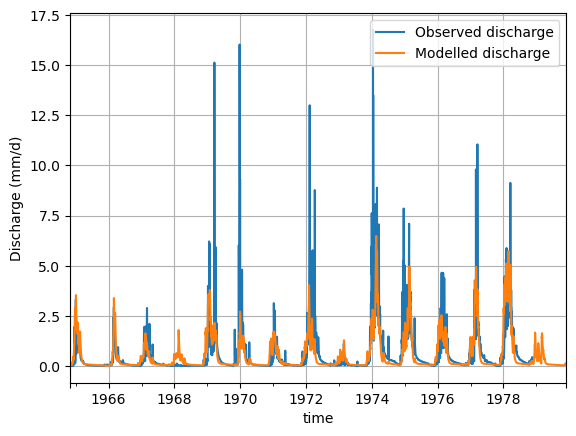

In [20]:
calibrate_forcing["Q"].plot(label="Observed discharge")
model_output.plot(label="Modelled discharge")
# calibrate_forcing["Q"].plot(label="Observed discharge")
plt.legend()
plt.grid()
plt.ylabel("Discharge (mm/d)")
plt.show()